# Differential interaction prediction during macrophage differentiation using UniversalEPI 
In this tutorial, we will be using already generated result files for [Reed et al (2022)](https://pubmed.ncbi.nlm.nih.gov/36323252/).

In [ ]:
# Import all the necessary libraries
import sys
if 'src' not in sys.path:
    sys.path.append('src')
import os
import warnings
warnings.filterwarnings("ignore")
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

import pyBigWig

np.random.seed(42)

In [2]:
# Define the region of interest
region = "chr12:43600000-44300000"

In [ ]:
# Load results and filter for the region of interest
chrom = int((region.split(":")[0]).split('chr')[-1])
seeds = [1337, 2714, 5040, 5452, 5895, 5994, 6286, 8737, 9354, 9597]
pred_dim = 200

def get_results(cell_line):
    variance_list = []
    predictions_list = []
    for i, seed in enumerate(seeds):
        results = np.load(f'../results/{cell_line}/paper-hg38-map-concat-stage1024-rf-lrelu-eval-stg-newsplit-newdata-atac-var-beta-neg-s{seed}/results.npz')
        if i == 0:
            targets = np.reshape(results['targets'], [-1, pred_dim])
        predictions_seed = np.reshape(results['predictions'], [-1, pred_dim])
        variance_seed = np.reshape(results['variance'], [-1, pred_dim])
        variance_list.append(variance_seed)
        predictions_list.append(predictions_seed)
    aleatoric_uncertainty = np.mean(variance_list, axis=0)
    predictions = np.mean(predictions_list, axis=0)
    predictions_std = np.std(predictions_list, axis=0, ddof=1)
    epistemic_uncertainty = predictions_std**2
    variance = aleatoric_uncertainty + epistemic_uncertainty
    predictions = np.clip(predictions, 0, None)

    res = 5000
    chr_data = np.reshape(results['chr'], [-1, pred_dim])
    pos1 = np.reshape(results['pos1'], [-1, pred_dim])//res
    pos2 = np.reshape(results['pos2'], [-1, pred_dim])//res
    print(targets.shape, predictions.shape, chr_data.shape, pos1.shape, pos2.shape)
    # Create result dataframe
    result_df = pd.DataFrame({
        'chrom': chr_data.flatten(),
        'bin1': pos1.flatten(),
        'bin2': pos2.flatten(),
        'target': targets.flatten(),
        'preds': predictions.flatten(),
        'variance': variance.flatten(),
    })
    result_df['dist'] = abs(result_df['bin2']-result_df['bin1'])
    result_df = result_df[result_df.dist < 203]
    result_df = result_df[result_df.chrom == chrom]
    return result_df

In [4]:
untreated_df = get_results('0000_merged')
treated_df = get_results('1440_merged')
treated_df.sort_values('preds', ascending=True, inplace=True)
untreated_df.sort_values('preds', ascending=True, inplace=True)
treated_df.drop_duplicates(['chrom', 'bin1', 'bin2'], keep='last', inplace=True)
untreated_df.drop_duplicates(['chrom', 'bin1', 'bin2'], keep='last', inplace=True)
print(untreated_df.shape, treated_df.shape)

(216863, 200) (216863, 200) (216863, 200) (216863, 200) (216863, 200)
(216863, 200) (216863, 200) (216863, 200) (216863, 200) (216863, 200)
(537737, 7) (537737, 7)


In [5]:
# Merge the two dataframes
merged_df = pd.merge(untreated_df, treated_df, on=['chrom', 'bin1', 'bin2'], suffixes=('_untreated', '_treated'))
merged_df.dropna(inplace=True)
print(merged_df.shape)

(537737, 11)


In [6]:
# Calculate the maximum confidence fold change
def get_max_conf_fc(mu1, mu2, var1, var2):
    calibration_constant = 0.0663
    if mu1 < mu2:
        d = (mu2-mu1) - calibration_constant*1.282*np.sqrt(var1+var2)
        if d < 0:
            return 0
        else:
            return (mu2-mu1)/np.log(2) - calibration_constant*1.282*np.sqrt((var1+var2)/np.log(2)**2)
    else:
        d = (mu2-mu1) + calibration_constant*1.282*np.sqrt(var1+var2)
        if d > 0:
            return 0
        else:
            return (mu2-mu1)/np.log(2) + calibration_constant*1.282*np.sqrt((var1+var2)/np.log(2)**2)

merged_df['max_conf_fc'] = merged_df.apply(lambda x: \
        get_max_conf_fc(x['preds_untreated'], x['preds_treated'], x['variance_untreated'], x['variance_treated']), axis=1)
merged_df_filtered = merged_df[(merged_df.max_conf_fc > np.log2(1.1)) | (merged_df.max_conf_fc < -np.log2(1.1))]
print(merged_df_filtered.shape)

(84955, 12)


In [7]:
# Get gene annotations
def process_gencode():
    gene_df = pd.read_csv("../data/genome/gencode.v47.annotation.gtf", sep="\t", comment="#", 
                            names=["chr", "source", "feature", "start", "end", "score", "strand", "frame", "attributes"])
    gene_df = gene_df[gene_df.feature == "gene"]
    gene_df["gene_name"] = gene_df.attributes.str.extract(r'gene_name "(.+?)";')
    gene_df['gene_type'] = gene_df.attributes.str.extract(r'gene_type "(.+?)";')
    gene_df = gene_df[gene_df.gene_type == "protein_coding"]
    gene_df = gene_df[['chr', 'start', 'end', 'gene_name', 'strand']]
    gene_df["tss"] = gene_df.apply(lambda x: x["start"] if x["strand"] == "+" else x["end"], axis=1)
    gene_df = gene_df.drop_duplicates(subset="gene_name")
    gene_df = gene_df.dropna()
    gene_df.to_csv("../data/genome/gencode_processed.csv", index=False)
    return gene_df

if os.path.isfile("../data/genome/gencode_processed.csv"):
    gene_df = pd.read_csv("../data/genome/gencode_processed.csv")
else:
    gene_df = process_gencode()
gene_df

,chr,start,end,gene_name,strand,tss
0,chr1,65419,71585,OR4F5,+,65419
1,chr1,450740,451678,OR4F29,-,451678
2,chr1,685716,686654,OR4F16,-,686654
3,chr1,923923,944575,SAMD11,+,923923
4,chr1,944203,959309,NOC2L,-,959309
...,...,...,...,...,...,...
20060,chrM,10470,10766,MT-ND4L,+,10470
20061,chrM,10760,12137,MT-ND4,+,10760
20062,chrM,12337,14148,MT-ND5,+,12337
20063,chrM,14149,14673,MT-ND6,-,14673


In [ ]:
# Plot arcs for a given region
res = 5000
def plot_arcs_differential(region, gene_df=gene_df, result_df=merged_df_filtered):
    
    chr, start, end = int((region.split(":")[0]).split('chr')[-1]), \
        int(region.split(":")[1].split("-")[0]), int(region.split(":")[1].split("-")[1])
    bin_start = start//res
    bin_end = end//res
    df_region = result_df[(result_df.chrom == chr) & (result_df.bin1 >= bin_start) & (result_df.bin2 <= bin_end)]
    df_region['pos1'] = df_region['bin1']*res
    df_region['pos2'] = df_region['bin2']*res
    

    # Normalize preds values for shading
    norm = mcolors.Normalize(vmin=-0.5, vmax=0.5)    
    cmap = cm.RdBu
    
    # Define genomic range
    chrom = "chr"+str(int(df_region["chrom"].iloc[0]))

    # Load ATAC-seq bigWig
    bw1 = pyBigWig.open(f"../data/atac/raw/0000_normalized.bw") 
    bw2 = pyBigWig.open(f"../data/atac/raw/1440_normalized.bw")
    positions = np.arange(start, end, 100, dtype=int)  # Sample every 100bp
    atac_signal1 = np.array([bw1.values(chrom, pos, pos + 100) for pos in positions])
    atac_signal1 = np.nan_to_num(atac_signal1)  # Replace NaNs with zeros
    bw1.close()

    atac_signal2 = np.array([bw2.values(chrom, pos, pos + 100) for pos in positions])
    atac_signal2 = np.nan_to_num(atac_signal2)  # Replace NaNs with zeros
    bw2.close()

    atac_signal1 = atac_signal1.max(axis=1)
    atac_signal2 = atac_signal2.max(axis=1)

    # Normalize genomic positions for plotting
    positions_kb = positions / 1000

    # Create figure with two subplots
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True, gridspec_kw={"height_ratios": [3, 1, 1, 0.5]}, dpi=100)

    # Plot 1: Hi-C Arcs
    axs[0].hlines(y=0, xmin=start/1000, xmax=end/1000, color='black', linewidth=1)
    for _, row in df_region.iterrows():
        x1, x2 = row["pos1"] / 1000, row["pos2"] / 1000
        arc_height = (x2 - x1) / 2  
        arc = np.linspace(0, np.pi, 100)
        arc_x = np.linspace(x1, x2, 100)
        arc_y = np.sin(arc) * arc_height
        color = cmap(norm(row["max_conf_fc"]))
        axs[0].plot(arc_x, arc_y, color=color, alpha=0.9)
    axs[0].set_title("{}: {:,}—{:,}".format(chrom, start, end))
    axs[0].set_ylabel("Predicted Differential Interactions")
    axs[0].set_yticks([])
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].spines["left"].set_visible(False)

    # Plot 2: ATAC-seq Signal
    axs[1].fill_between(positions_kb, atac_signal1, color="red", alpha=0.7)
    axs[1].set_ylabel("ATAC-seq\n(before treatment)")
    axs[1].set_xlim(start / 1000, end / 1000)  # Keep X-axis consistent
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["bottom"].set_visible(False)

    # Plot 3: ATAC-seq Signal
    axs[2].fill_between(positions_kb, atac_signal2, color="blue", alpha=0.7)
    axs[2].set_ylabel("ATAC-seq\n(after treatment)")
    axs[2].set_xlim(start / 1000, end / 1000)  # Keep X-axis consistent
    axs[2].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["bottom"].set_visible(False)

    # Plot 4: Gene Annotations
    gene_df = gene_df[gene_df.chr == chrom]
    gene_df = gene_df[(gene_df.end >= start) & (gene_df.start <= end)]
    for i, row in gene_df.iterrows():
        y_pos = (i+1) % 2 * 0.3  # Alternates between 0 and 0.3 to stagger labels
        j=0.25
        axs[3].hlines(y=j+y_pos, xmin=row["start"] / 1000, xmax=row["end"] / 1000, color="black", linewidth=3)
        if row['tss'] < start or row['tss'] > end:
            pass
        else:
            axs[3].text(row['tss']/1000, j-0.15-y_pos, row["gene_name"], ha="center", va="top", fontsize=8)
        tss_kb = row["tss"] / 1000
        if row["strand"] == '+':  
            triangle_coords = [(tss_kb, j+y_pos), (tss_kb, j+y_pos + 0.4), (tss_kb + 0.3, j+y_pos)]  # Right-facing
        else:
            triangle_coords = [(tss_kb, j+y_pos), (tss_kb, j+y_pos + 0.4), (tss_kb - 0.3, j+y_pos)]  # Left-facing

        # Add triangle to plot
        triangle = Polygon(triangle_coords, closed=True, facecolor="black", edgecolor="black")
        axs[3].add_patch(triangle)

    axs[3].set_yticks([])
    axs[3].set_xlabel("Genomic Position (Kb)")
    axs[3].set_xlim(start / 1000, end / 1000)  # Keep X-axis consistent
    axs[3].set_ylim(-1, 1)
    axs[3].set_ylabel("Genes")
    axs[3].spines["top"].set_visible(False)
    axs[3].spines["right"].set_visible(False)
    axs[3].spines["left"].set_visible(False)


    # Remove top subplot's X-axis ticks for cleaner look
    axs[0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    axs[1].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    axs[2].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    # Add colorbar to whole figure
    fig.subplots_adjust(right=0.89)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, cax=cbar_ax, label="Max. Confidence Fold Change (treated / untreated)")
    plt.show()

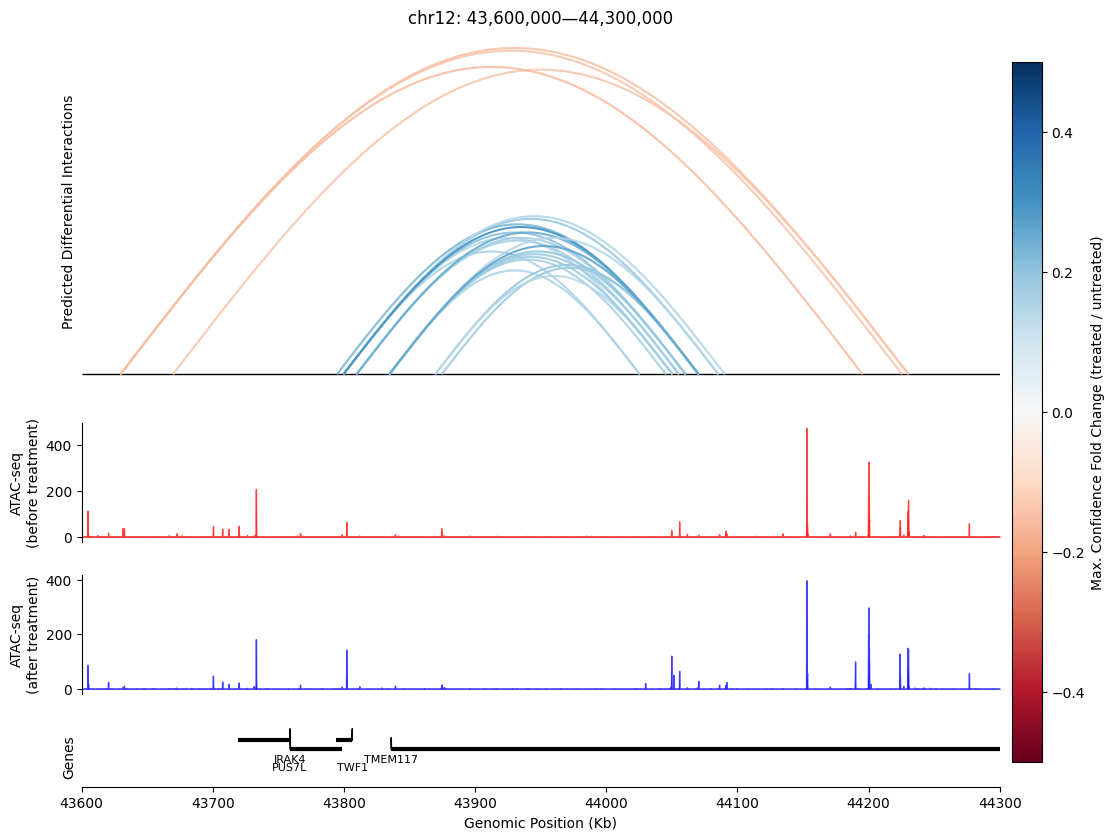

In [9]:
plot_arcs_differential(region)